In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from openpyxl import load_workbook
from numba import jit

In [18]:
# Define the boundary and well radius
l = 4.0
r_out = 0.9
r_in = 0.1 + (r_out-0.9)     #well radius
b = r_out
w_h = 1.5   #well height
cap = 2.3   #cap height
eff_dep = 0.5   #position of effective depth of well
fps=30
# Define the diffusion coefficient and beta value
r_bead = 0.1
D_0 = 1.005
r_0 = 0.1
k = D_0*r_0
D = k/r_bead
beta = 3.0

# Define the step size and the total simulation time
dx = dy = dz = 0.04

# Choose the excel file to save data
path = "./Excel/"+str(D)+'_'+str(fps)+'Hz_step_size='+str(dx)+'_angle_rim.xlsx'


0.12962962962962965


Text(0.5, 1.0, 'Geometric well')

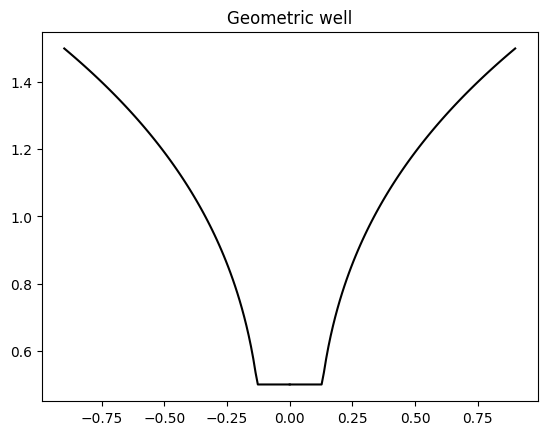

In [3]:
import warnings
# Well
eff_r_in = (r_out-r_in)*((((eff_dep-w_h)/w_h)+1)**3)+r_in
print(eff_r_in)
@jit(nopython=True)
def well_z(r):
    #warnings.filterwarnings("ignore")
    return (r > r_out)*w_h \
          +(r > eff_r_in)*(r <= r_out)*np.nan_to_num(-w_h*(1-((r-r_in)/(r_out-r_in))**(1/3))+w_h)\
          +(r <= eff_r_in)*eff_dep
@jit(nopython=True)
def well_r(z_pos):
    return (r_out-r_in)*((((z_pos-w_h)/w_h)+1)**3)+r_in
"""
@jit(nopython=True)
def well_z(r):
    #warnings.filterwarnings("ignore")
    return w_h*np.ones_like(r)
@jit(nopython=True)
def well_r(z_pos):
    return r_out
    """
r_span= np.linspace(0, r_out, 100)
z_span= np.linspace(eff_dep, w_h, 100)
plt.plot(r_span,well_z(r_span),color="black")
plt.plot(-r_span,well_z(r_span),color="black")
plt.title("Geometric well")
#plt.plot(z_span,well_r(z_span))

Maximum dwell time at log10(t) = -0.8894618072532053


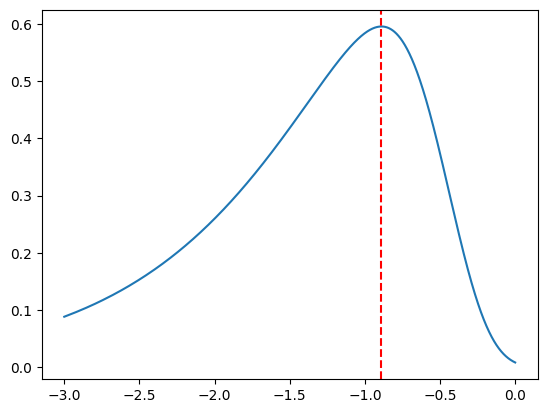

In [4]:
from scipy.special import jn_zeros
n=100
jn_zero = jn_zeros(0, n)
def dwell(t):
    return 4*np.sum(np.exp(-jn_zero[None,:]**2*t[:,None]),axis=1)
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
x_max=x[np.argmax(y)]
print("Maximum dwell time at log10(t) =", x_max)
plt.plot(x,y , label="Dwell time")
plt.axvline(x_max, color='red', linestyle='--', label='Max dwell time')

In [ ]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_wander(L_max=10**3):
    #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6

    # Define the initial state of the nanoparticle
    x = 1.2
    y = 0.4
    z = 1.0
    t = 0.0
    radius = np.sqrt(x**2+y**2)
    #x_track[0],y_track[0],z_track[0],t_track[0]=x,y,z,t

    # IN = 1, OUT = 0
    if radius<=0.9:
        prev_in_well=1
    else:
        prev_in_well=0
    dwell_track=np.zeros((L_max))
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        
        # IN = 1, OUT = 0
        if radius <= 0.9:
            if prev_in_well==0:
                L+=1
                enter_track[L]=shift(np.array([avg_x,avg_y]))
            dwell_track[L]+=1/fps
            prev_in_well=1
        else:
            if prev_in_well==1:
                leave_track[L]=shift(np.array([avg_x,avg_y]))
                angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            prev_in_well=0
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_wander(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



2.2006843090057373


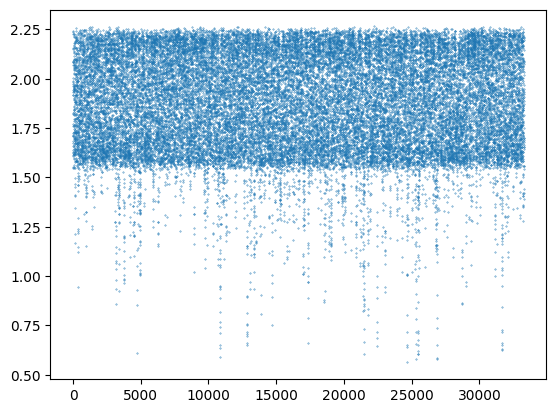

In [6]:
plt.scatter(np.arange(len(z)),z,s=0.1)

Vanilla Gillipise:57.21725916862488

Jit python Gillispie:3.4

10**3: 3.4

10**4:9.3

10**5: 31.87

10**6: 10 min

In [6]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_restart(L_max=10**3):
    #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6
    # Define the initial state of the nanoparticle
    r=np.random.uniform(low=0.0, high=r_out)
    theta=np.random.uniform(low=0.0, high=2*np.pi)
    z_min= well_z(r)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.random.uniform(low=z_min, high=cap)
    t = 0.0
    dwell_track=np.zeros(L_max)
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        if radius <= 0.9:
            dwell_track[L]+=1/fps
        else:
            L+=1
            leave_track[L]=shift(np.array([avg_x,avg_y]))
            angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            r=np.random.uniform(low=0.0, high=r_out)
            theta=np.random.uniform(low=0.0, high=2*np.pi)
            z_min= well_z(r)
            x = r*np.cos(theta)
            y = r*np.sin(theta)
            z = np.random.uniform(low=z_min, high=cap)
            enter_track[L]=shift(np.array([x,y]))
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_restart(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



912.4440407752991


In [17]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_rim(L_max=10**3):
   #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6
    # Define the initial state of the nanoparticle
    r=r_out
    theta=np.random.uniform(low=0.0, high=2*np.pi)
    z_min= well_z(r)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.random.uniform(low=z_min, high=cap)
    t = 0.0
    dwell_track=np.zeros(L_max)
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        if radius <= 0.9:
            dwell_track[L]+=1/fps
        else:
            L+=1
            leave_track[L]=shift(np.array([avg_x,avg_y]))
            angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            r=r_out
            theta=np.random.uniform(low=0.0, high=2*np.pi)
            z_min= well_z(r)
            x = r*np.cos(theta)
            y = r*np.sin(theta)
            z = np.random.uniform(low=z_min, high=cap)
            enter_track[L]=shift(np.array([x,y]))
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_rim(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



76.59766793251038


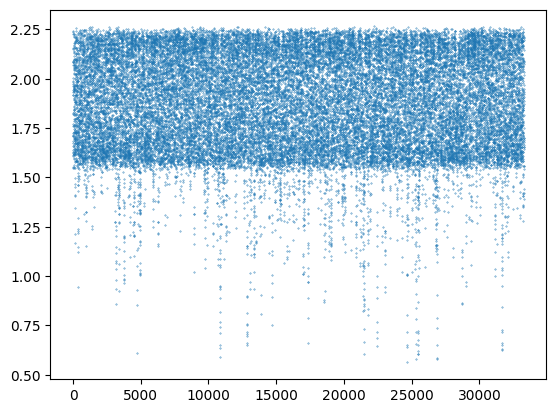

In [10]:
plt.scatter(np.arange(len(z)),z,s=0.1)

In [5]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook

In [37]:
print(angle_track.shape)
#print(leave_track)

(1000000,)


In [19]:
with pd.ExcelWriter(path, engine='openpyxl') as writer:
	d = {'dwell_time': dwell_track[1:-1],"angle":angle_track[1:-1]}
	df = pd.DataFrame(data = d)
	df.to_excel(writer, index = True, sheet_name = 'dwell time')
	

In [39]:
"""
import plotly.express as px
import plotly.graph_objects as go

fig =go.Figure(data=px.scatter_3d(df, x='x', y='y', z='z',color='t'))
x_scale=np.max(df['x'])-np.min(df['x'])
y_scale=np.max(df['y'])-np.min(df['y'])
Max=max(x_scale,y_scale)
fig.update_traces(marker_size = 3)
fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        aspectratio = dict( x=x_scale*0.9/Max, y=y_scale/Max, z=0.7),
        aspectmode = 'manual'
    ),
)
#for i in range(-2,2):
    #for j in range(-4,1):
        #fig.add_trace(go.Surface(z=Z, x=x+i*l, y=y+j*l, opacity=0.5, colorscale='Blues'))
fig.show()
"""

"\nimport plotly.express as px\nimport plotly.graph_objects as go\n\nfig =go.Figure(data=px.scatter_3d(df, x='x', y='y', z='z',color='t'))\nx_scale=np.max(df['x'])-np.min(df['x'])\ny_scale=np.max(df['y'])-np.min(df['y'])\nMax=max(x_scale,y_scale)\nfig.update_traces(marker_size = 3)\nfig.update_layout(\n    width=800,\n    height=700,\n    autosize=False,\n    scene=dict(\n        aspectratio = dict( x=x_scale*0.9/Max, y=y_scale/Max, z=0.7),\n        aspectmode = 'manual'\n    ),\n)\n#for i in range(-2,2):\n    #for j in range(-4,1):\n        #fig.add_trace(go.Surface(z=Z, x=x+i*l, y=y+j*l, opacity=0.5, colorscale='Blues'))\nfig.show()\n"

In [10]:
path0= './Excel/1.005_30Hz_step_size=0.04_angle_restart.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')
path1= './Excel/1.005_1000Hz_step_size=0.04_angle_restart.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')

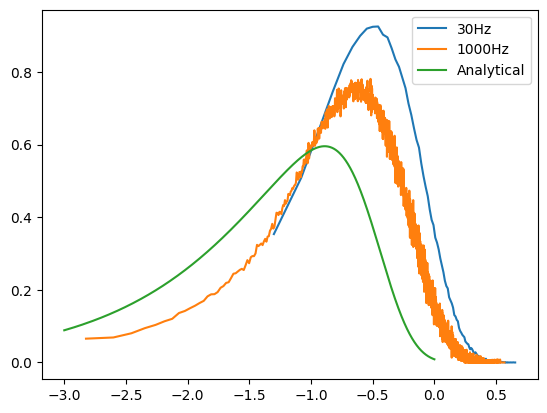

In [11]:
Time0=data0['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time1=data1['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge1=np.arange(1/1000,np.max(Time1),1/1000)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(Time0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(Time1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
plt.plot(np.log10(bin_center0),bin_center0*hist0*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center1),bin_center1*hist1*np.log(10),label='1000Hz')
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
plt.plot(x,y , label="Analytical")
plt.legend()


In [24]:
path0= './Excel/1.005_30Hz_step_size=0.04_angle_rim.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')
path1= './Excel/1.005_30Hz_step_size=0.04_angle_wander.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')

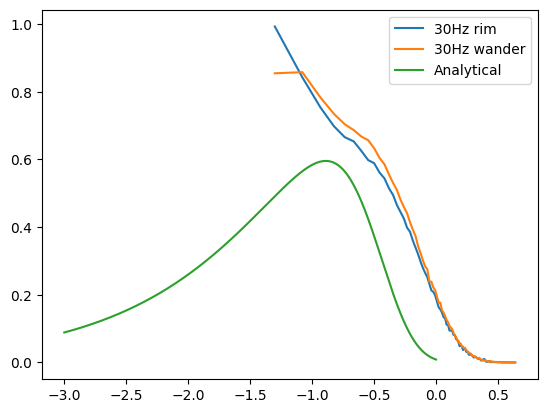

In [25]:
Time0=data0['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time1=data1['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(Time0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(Time1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
plt.plot(np.log10(bin_center0),bin_center0*hist0*np.log(10),label='30Hz rim')
plt.plot(np.log10(bin_center1),bin_center1*hist1*np.log(10),label='30Hz wander')
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
plt.plot(x,y , label="Analytical")
plt.legend()


(130,)


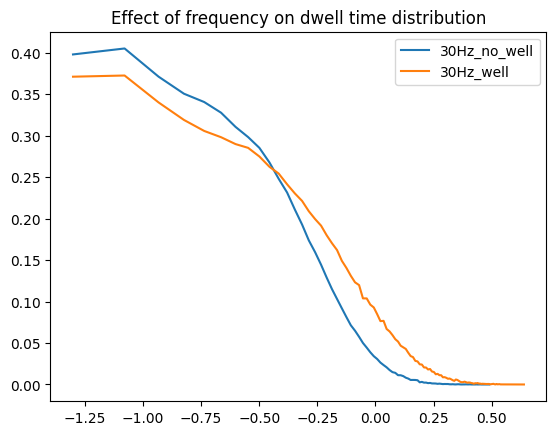

In [88]:
Time0=data0['dwell_time']
angle0=data0['angle']
angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(angle_0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy))
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy))
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy))
cum4=np.cumsum(hist4)
plt.title("Effect of frequency on dwell time distribution")
print(cum1.shape)
plt.plot(np.log10(bin_center0),hist0*bin_center0,label='30Hz_no_well')
plt.plot(np.log10(bin_center1),hist1*bin_center1,label='30Hz_well')
plt.legend()


In [17]:
print(np.nan_to_num(np.log10(hist1), nan=0.0, posinf=0, neginf=0))

[5.39333825 5.17314838 4.98742045 4.85047469 4.7448404  4.66141511
 4.5870596  4.52579607 4.46136345 4.39778363 4.34460838 4.2857148
 4.23200448 4.18358299 4.12949654 4.08217478 4.03905702 3.98775562
 3.94106399 3.89784693 3.84098384 3.79532376 3.74616696 3.70122248
 3.67191301 3.59284268 3.57668681 3.52853106 3.49789674 3.4440448
 3.38471174 3.372912   3.30037806 3.26787542 3.22427401 3.17493159
 3.13987909 3.08421869 3.05461305 3.02448567 2.96473092 2.90579588
 2.88024178 2.80550086 2.78604121 2.7176705  2.70415052 2.62634037
 2.61595005 2.55388303 2.55870857 2.47275645 2.44870632 2.35410844
 2.36361198 2.29666519 2.28780173 2.17026172 2.17026172 2.12385164
 2.04921802 2.06069784 1.99122608 1.89762709 1.8260748  1.95424251
 1.90848502 1.79239169 1.66275783 1.59106461 1.60205999 1.67209786
 1.56820172 1.462398   1.50514998 1.47712125 1.34242268 1.2787536
 1.04139269 1.2787536  1.23044892 1.32221929 1.11394335 1.11394335
 0.90308999 1.         0.95424251 0.90308999 0.84509804 0.7781512

C:\Users\User\AppData\Local\Temp\ipykernel_44292\1067166867.py:1: RuntimeWarning: divide by zero encountered in log10
  print(np.nan_to_num(np.log10(hist1), nan=0.0, posinf=0, neginf=0))


-3.1193713403236276 0.820697989562816


C:\Users\User\AppData\Local\Temp\ipykernel_60488\2056329822.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(bin_center1,np.nan_to_num(np.log(hist1), nan=0.0, posinf=0, neginf=0),label='30Hz')


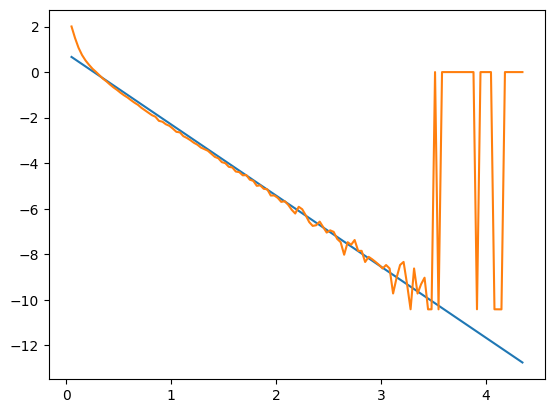

In [16]:

m,c=np.polyfit(bin_center1[:-28],np.nan_to_num(np.log(hist1[:-28]), nan=0.0, posinf=0, neginf=0),deg=1)
print(m,c)
plt.plot(bin_center1,m*bin_center1+c,label='30Hz fit')
plt.plot(bin_center1,np.nan_to_num(np.log(hist1), nan=0.0, posinf=0, neginf=0),label='30Hz')

In [104]:
print(np.exp(-3.1193713403236276))

0.04418493697847316


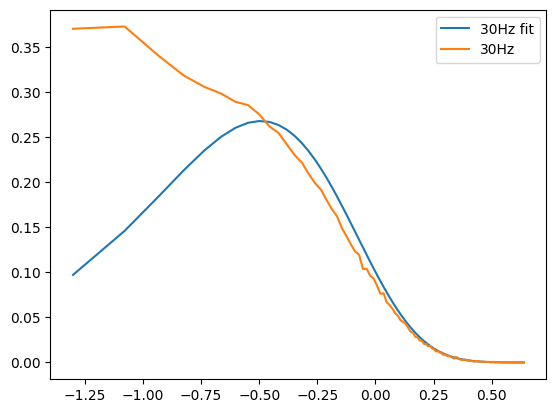

In [17]:
A=np.exp(c)
#bin_edge1=np.arange(1/30,np.max(Time1),1/30)
#bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
plt.plot(np.log10(bin_center1),A*np.exp(m*bin_center1)*bin_center1,label='30Hz fit')
plt.plot(np.log10(bin_center1),hist1*bin_center1,label='30Hz')
plt.legend()

In [31]:
print(A,m)

75740.41034798577 -3.1194059284577773


In [33]:
print(np.log10(A*np.exp(m* bin_edge1)))

[6.91143883 6.64049067 6.36954251 6.09859436 5.8276462  5.55669804
 5.28574989 5.01480173 4.74385358 4.47290542 4.20195726 3.93100911]


(130,)


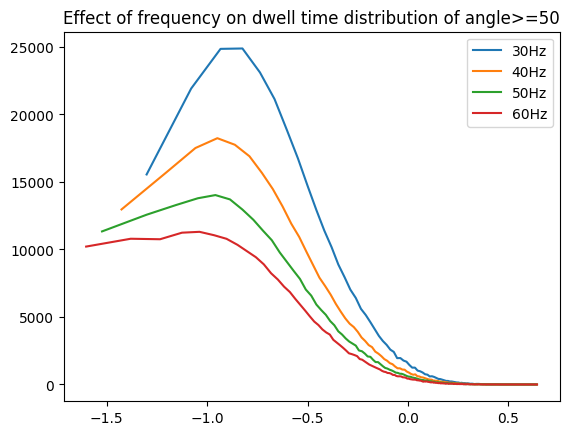

In [8]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1>=50/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2>=50/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3>=50/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4>=50/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
accuracy=4
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy))
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy))
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy))
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy))
cum4=np.cumsum(hist4)
plt.title("Effect of frequency on dwell time distribution of angle>=50")
print(cum1.shape)
plt.plot(np.log10(bin_center1),hist1,label='30Hz')
plt.plot(np.log10(bin_center2),hist2,label='40Hz')
plt.plot(np.log10(bin_center3),hist3,label='50Hz')
plt.plot(np.log10(bin_center4),hist4,label='60Hz')
plt.legend()

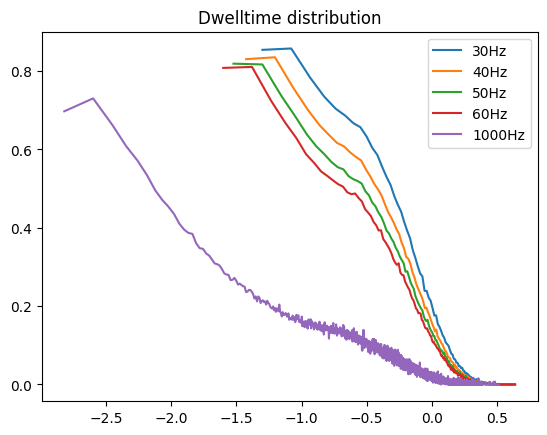

In [31]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=180/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=180/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=180/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=180/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2

Time5=data5['dwell_time']
angle5=data5['angle']
angle_5=Time5[angle5<=180/180*np.pi]
bin_edge5=np.arange(1/1000,np.max(Time5),1/1000)
bin_center5 = (bin_edge5[:-1] + bin_edge5[1:]) / 2
accuracy=5
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy),density=True)
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy),density=True)
cum4=np.cumsum(hist4)
hist5,bin5= np.histogram(np.round(angle_5,decimals=accuracy), bins =np.round(bin_edge5,decimals=accuracy),density=True)
cum5=np.cumsum(hist5)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
plt.title("Dwelltime distribution")
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center2),hist2*bin_center2*np.log(10),label='40Hz')
plt.plot(np.log10(bin_center3),hist3*bin_center3*np.log(10),label='50Hz')
plt.plot(np.log10(bin_center4),hist4*bin_center4*np.log(10),label='60Hz')
plt.plot(np.log10(bin_center5),hist5*bin_center5*np.log(10),label='1000Hz')
plt.legend()

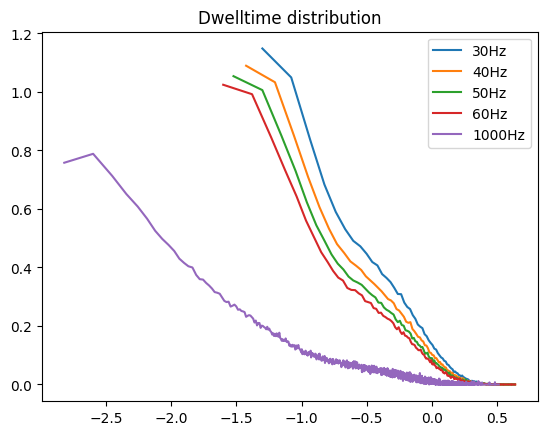

In [32]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=50/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=50/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=50/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=50/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2

Time5=data5['dwell_time']
angle5=data5['angle']
angle_5=Time5[angle5<=50/180*np.pi]
bin_edge5=np.arange(1/1000,np.max(Time5),1/1000)
bin_center5 = (bin_edge5[:-1] + bin_edge5[1:]) / 2
accuracy=5
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy),density=True)
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy),density=True)
cum4=np.cumsum(hist4)
hist5,bin5= np.histogram(np.round(angle_5,decimals=accuracy), bins =np.round(bin_edge5,decimals=accuracy),density=True)
cum5=np.cumsum(hist5)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
plt.title("Dwelltime distribution")
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center2),hist2*bin_center2*np.log(10),label='40Hz')
plt.plot(np.log10(bin_center3),hist3*bin_center3*np.log(10),label='50Hz')
plt.plot(np.log10(bin_center4),hist4*bin_center4*np.log(10),label='60Hz')
plt.plot(np.log10(bin_center5),hist5*bin_center5*np.log(10),label='1000Hz')
plt.legend()

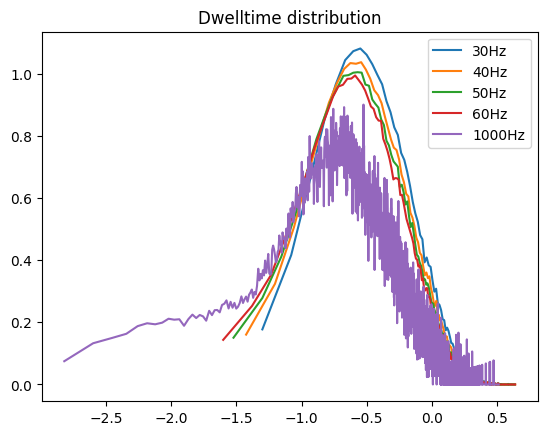

In [35]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1>=50/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2>=50/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3>=50/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4>=50/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2

Time5=data5['dwell_time']
angle5=data5['angle']
angle_5=Time5[angle5>=50/180*np.pi]
bin_edge5=np.arange(1/1000,np.max(Time5),1/1000)
bin_center5 = (bin_edge5[:-1] + bin_edge5[1:]) / 2
accuracy=6
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy),density=True)
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy),density=True)
cum4=np.cumsum(hist4)
hist5,bin5= np.histogram(np.round(angle_5,decimals=accuracy), bins =np.round(bin_edge5,decimals=accuracy),density=True)
cum5=np.cumsum(hist5)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
plt.title("Dwelltime distribution")
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center2),hist2*bin_center2*np.log(10),label='40Hz')
plt.plot(np.log10(bin_center3),hist3*bin_center3*np.log(10),label='50Hz')
plt.plot(np.log10(bin_center4),hist4*bin_center4*np.log(10),label='60Hz')
plt.plot(np.log10(bin_center5),hist5*bin_center5*np.log(10),label='1000Hz')
plt.legend()

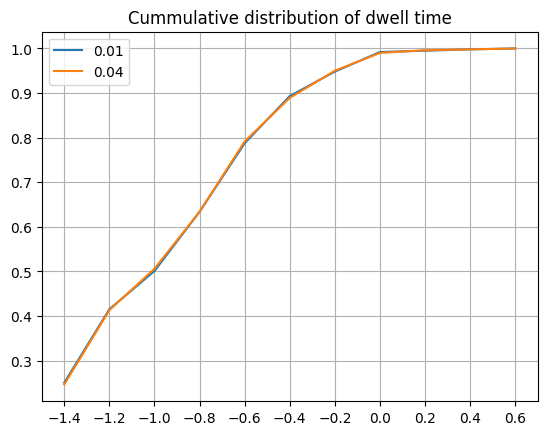

In [ ]:
dx3 = bin3[1] -bin3[0]
dx4 = bin3[1] -bin3[0]
F3 = np.cumsum(hist3)*dx3
F4 = np.cumsum(hist4)*dx4
plt.plot(bin_center2, F3,label='0.01')
plt.plot(bin_center2, F4,label='0.04')
plt.xticks(bin_center2)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()

0.04003403980420894


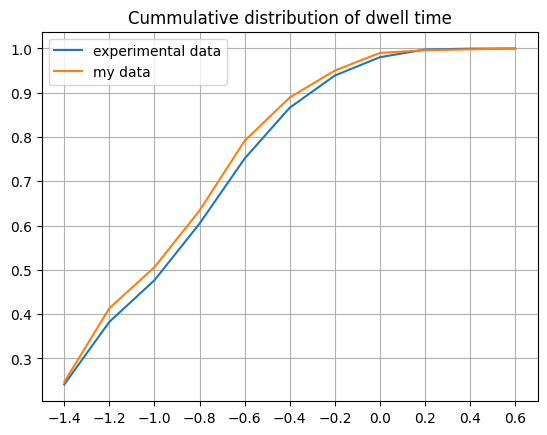

In [ ]:
dx3 = bin3[1] -bin3[0]
dx4 = bin3[1] -bin3[0]
F5 = np.cumsum(frequency6[:-6])*dx3
F4 = np.cumsum(hist4)*dx4
plt.plot(bin_center2, F5,label='experimental data')
plt.plot(bin_center2, F4,label='my data')
plt.xticks(bin_center2)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()
KS_stat=np.max(np.abs(F5-F4))
print(KS_stat)

0.006183584657423302


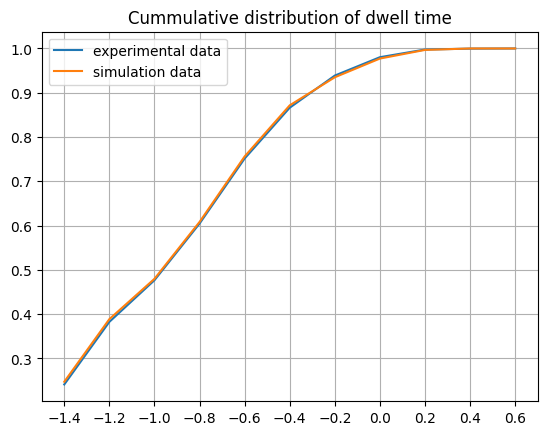

In [ ]:
dx3 = bin3[1] -bin3[0]
dx4 = bin3[1] -bin3[0]
F6= np.cumsum(frequency6[:-6])*dx3
F7 = np.cumsum(frequency7[:-6])*dx4
plt.plot(bin_center2, F6,label='experimental data')
plt.plot(bin_center2, F7,label='simulation data')
plt.xticks(bin_center2)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()
KS_stat=np.max(np.abs(F6-F7))
print(KS_stat)